In [1]:
!pip3 install -q torch_snippets
from torch_snippets import * 
from torchvision.datasets import MNIST 
from torchvision import transforms 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device



/home/delameta/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
img_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [3]:
trn_ds = MNIST('../public/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('../public/content/', transform=img_transform, train=False, download=True)

In [4]:
batch_size = 256 
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True), 
            nn.Linear(128,64), 
            nn.ReLU(True), 
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), 
            nn.ReLU(True), 
            nn.Linear(64,128), 
            nn.ReLU(True), 
            nn.Linear(128, 28*28), 
            nn.Tanh())
    
    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x 
        




In [6]:
!pip3 install torch_summary
from torchsummary import summary 
model = AutoEncoder(3).to(device)
summary(model, torch.zeros(2,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

EPOCH: 1.000	trn_loss: 0.247	val_loss: 0.186	(17.54s - 70.14s remaining)


100%|██████████| 106/106 [00:00<00:00, 11068.97it/s]


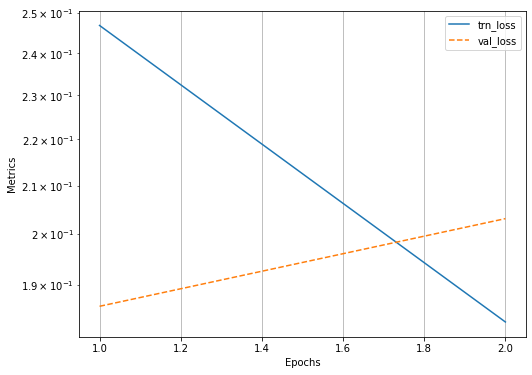

EPOCH: 2.000	trn_loss: 0.175	val_loss: 0.167	(35.86s - 53.78s remaining)


100%|██████████| 106/106 [00:00<00:00, 9279.43it/s]


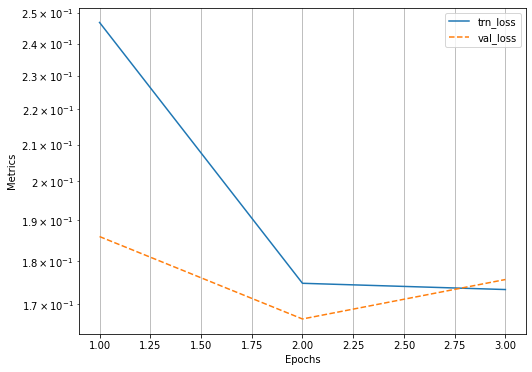

EPOCH: 3.000	trn_loss: 0.162	val_loss: 0.157	(53.38s - 35.59s remaining)


100%|██████████| 106/106 [00:00<00:00, 6388.70it/s]


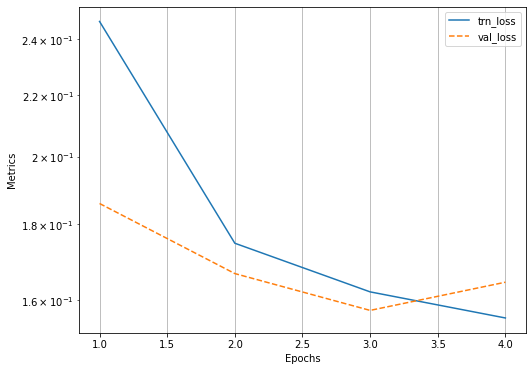

EPOCH: 4.000	trn_loss: 0.155	val_loss: 0.152	(70.75s - 17.69s remaining)


100%|██████████| 106/106 [00:00<00:00, 5098.17it/s]


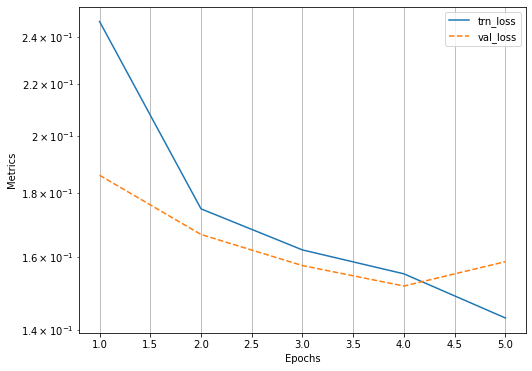

EPOCH: 5.000	trn_loss: 0.150	val_loss: 0.148	(88.25s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 3795.23it/s]


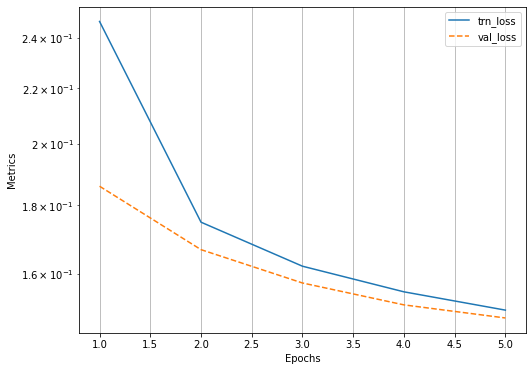

In [7]:
def train_batch(input, model, criterion, optimizer):
    model.train() 
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss 

@torch.no_grad()
def validate_batch(input, model, criterion, optimizer):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss 

model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5 
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')
    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)
    log.plot_epochs(log=True)

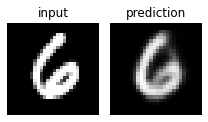

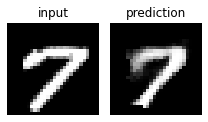

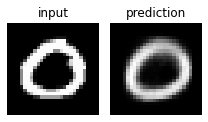

In [8]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1, 2, figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

In [9]:
# define path2weights
path2weights="../public/weights/weights.pt"
# store state_dict to file
torch.save(model.state_dict(), path2weights)
# define model: weights are randomly initiated
_model = model
weights=torch.load(path2weights)
_model.load_state_dict(weights)

In [10]:
path2weights="../public/weights/weight.pt"
torch.save(model.state_dict(), path2weights)
_model = model
weights= torch.load(path2weights)
_model.load_state_dict(path2weights)


AttributeError: 'str' object has no attribute 'copy'